In [8]:
# from getopt import getopt
# import cloudpickle
# import pickle
# import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli, betabinom
# from scipy.stats import linregress
# from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
from time import time, sleep
# from datetime import timedelta

In [9]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

from statsmodels.stats.proportion import proportions_ztest, proportions_ztost, test_proportions_2indep
from statsmodels.stats.nonparametric import rank_compare_2indep
from statsmodels.stats.weightstats import ttest_ind, ttost_ind
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, ttest_rel

## Bayesian Scores

In [10]:
def run_command_gnome(command, title="test", keep_window=False, test=False):
    if keep_window:
        command_suffix = "; $SHELL"
    else:
        command_suffix = ""
        
    if test:
        return f"""gnome-terminal --title="{title}" --command="bash -c '{command} {command_suffix}'" """
    else:
        os.system(f"""gnome-terminal --title="{title}" --command="bash -c '{command} {command_suffix}'" """)

In [11]:
# Run simulations
def run_simulations(n_runs=30):
    setting_files = [os.path.isfile(f"data/{sim_name}/sim_settings_{i}.csv") for i in range(N_PROCESSES)]
    process_active = [os.path.isfile(f"data/{sim_name}/process_{i}_running") for i in range(N_PROCESSES)]
    while sum(setting_files)>0:
        for i in range(N_PROCESSES):
            if setting_files[i] and not process_active[i]:
                source = "source ~/anaconda3/etc/profile.d/conda.sh\n"
                conda = "conda activate bayes_topic_measures\n"
                c = f"""python3 perform_sig_test.py --trials_per_sim {trials_per_sim} --process {i} --sim_name {sim_name} --optimal_alloc {optimal_alloc}"""
                run_command_gnome(source+conda+c, title=f"p{i}", keep_window=False)

        sleep(10)
        setting_files = [os.path.isfile(f"data/{sim_name}/sim_settings_{i}.csv") for i in range(N_PROCESSES)]
        process_active = [os.path.isfile(f"data/{sim_name}/process_{i}_running") for i in range(N_PROCESSES)]

In [12]:
# Settings for hoyle's significance testing
hoyle_total_scores = 2*50*26
hoyle_p_diff = 0.055
hoyle_n_raters = 38
hoyle_scores_per_r = hoyle_total_scores//hoyle_n_raters + 1

In [13]:
# Varying the number of raters
N_PROCESSES = 4
sim_name0 = "6_power_comp"
sim_name1 = "6_power_compOA"

n_sims = 144
trials_per_sim = 1
p_diff = hoyle_p_diff
n_raters = hoyle_n_raters
scores_per_r = hoyle_scores_per_r

In [29]:
# Removing all produced files
os.system(f"""rm data/simulations/{sim_name0}.csv""")
os.system(f"""rm data/simulations/{sim_name1}.csv""")
os.system(f"""rm data/{sim_name0}/*""")
os.system(f"""rm -rf data/{sim_name1}""")

# Generate settings file
os.system(f"""
    python3 generate_sim_settings.py --n_raters "{n_raters}" --scores_per_r {scores_per_r} \
    --n_sims {n_sims} --trials_per_sim {trials_per_sim} --sim_name {sim_name0} 
""")

os.system(f"cp -r data/{sim_name0} data/{sim_name1}")
os.system(f"cp data/simulations/{sim_name0}.csv data/simulations/{sim_name1}.csv")

rm: cannot remove 'data/simulations/6_power_compOA.csv': No such file or directory



    p_diff=0.055, <class 'float'>
    n_raters=38, <class 'int'>
    scores_per_r=69, <class 'int'>
    total_scores=None, <class 'NoneType'>
    n_sims=144, <class 'int'>
    trials_per_sim=1
    seed=42, <class 'int'>
    sim_name=6_power_comp, <class 'str'>
    chain_method=vectorized, <class 'str'>
    clean_dir=True, <class 'bool'>
    


0

In [30]:
n_runs = 8

sim_name = sim_name0
optimal_alloc = False
run_simulations(n_runs=n_runs)

sim_name = sim_name1
optimal_alloc = True
run_simulations(n_runs=n_runs)

# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “--command” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to termin

In [32]:
scores = pd.DataFrame()

for sim_id in range(n_sims*4//6):
    a = pd.read_csv(f"data/{sim_name0}/score_{sim_id}.csv")
    a.insert(0, "sim_id", sim_id)
    scores = pd.concat([scores, a])


In [33]:
# Aggregating cordel model precision from scores
sums = (scores.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
counts = (scores.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
postrr_scores = pd.merge(sums, counts, on=["sim_id","sim_cordel_id","sim_topic_id"])
postrr_scores["model_precision"] = postrr_scores["sum"]/postrr_scores["count"]

In [38]:
scoresOA = pd.DataFrame()

for sim_id in range(n_sims*4//6):
    a = pd.read_csv(f"data/{sim_name1}/score_{sim_id}.csv")
    a.insert(0, "sim_id", sim_id)
    scoresOA = pd.concat([scoresOA, a])


In [39]:
# Aggregating cordel model precision from scoresOA
sums = (scoresOA.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
counts = (scoresOA.groupby(["sim_id","sim_cordel_id","sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
postrr_scoresOA = pd.merge(sums, counts, on=["sim_id","sim_cordel_id","sim_topic_id"])
postrr_scoresOA["model_precision"] = postrr_scoresOA["sum"]/postrr_scoresOA["count"]

## Hoyle Simulations

In [21]:
def rand_bin_array(topics, questions=30):
    selections = np.zeros(topics)
    selections[:questions]  = 1
    np.random.shuffle(selections)
    return selections

def permutation_test(a, b, alternative="two-sided", value=0, iters=1000):
    og_diff = np.mean(a) - np.mean(b) - value
    combin = np.concatenate([a, b])
    n_a, n_b = len(a), len(b)
    diffs = [
        np.mean(samp[:n_a]) - np.mean(samp[n_a:])
        for _ in range(iters)
        for samp in [np.random.choice(combin, n_a + n_b, replace=False)]
    ]
    if alternative == "two-sided":
        return og_diff, np.mean(np.abs(og_diff) < np.abs(diffs)), diffs
    elif alternative == "larger":
        return og_diff, np.mean(og_diff < diffs), diffs
    elif alternative == "smaller":
        return og_diff, np.mean(og_diff > diffs), diffs
    else:
        raise ValueError("alternative must be one of (two-sided, larger, smaller)")

In [22]:
# params
topics = 50
annotators_per_topic = 26
prob_correct = np.array([
    1/6, # how often someone selects the intruder for an incoherent topic
    0.85, # how often someone selects the intruder for a coherent topic. estimated from chang 2009: avg. % correct of the 10% most-correct topics
])
bad_topic_difference = 4 # effect size (number of bad topics in model a vs model b)
h0 = 0.0

# simulation
iter = 40
# pvals = []
# alternative = "larger" if h0 == 0 else "smaller"
# np.random.seed(454)

hoyle_scores = pd.DataFrame()

for i in range(iter):
    # create topics for both models
    model_a_topics = np.random.choice([0, 1], topics)
    if model_a_topics.sum() - bad_topic_difference < 0:
        continue
    model_b_topics = np.zeros(topics, dtype=int)
    model_b_topics[:int(model_a_topics.sum() - bad_topic_difference)] = 1

    # simulate responses
    n = topics*annotators_per_topic
    topic_assignments = annotators_per_topic
    prob_a = prob_correct[model_a_topics]
    model_a_responses = np.random.binomial(n=topic_assignments, p=prob_a)
    prob_b = prob_correct[model_b_topics]
    model_b_responses = np.random.binomial(n=topic_assignments, p=prob_b)
    
    a = pd.DataFrame(
        np.array([[i]*topics, [1]*topics, [i for i in range(topics)],
                 model_a_responses, [annotators_per_topic]*topics]).T,
        columns=["sim_id", "sim_cordel_id", "sim_topic_id", "sum", "count"]
    )
    b = pd.DataFrame(
        np.array([[i]*topics, [0]*topics, [i for i in range(topics)],
                 model_b_responses, [annotators_per_topic]*topics]).T,
        columns=["sim_id", "sim_cordel_id", "sim_topic_id", "sum", "count"]
    )
    hoyle_scores = pd.concat([hoyle_scores, a, b])

hoyle_scores["model_precision"] = hoyle_scores["sum"]/hoyle_scores["count"]

## Observed Scores

In [19]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)

corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 

d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [20]:
# Aggregating cordel model precision from scores
sums = (data.groupby(["cordel_id","topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
counts = (data.groupby(["cordel_id","topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
obs_scores = pd.merge(sums, counts, on=["cordel_id","topic_id"])
obs_scores["model_precision"] = postrr_scores["sum"]/postrr_scores["count"]

## Plots

In [27]:
bw_adjust=0.3

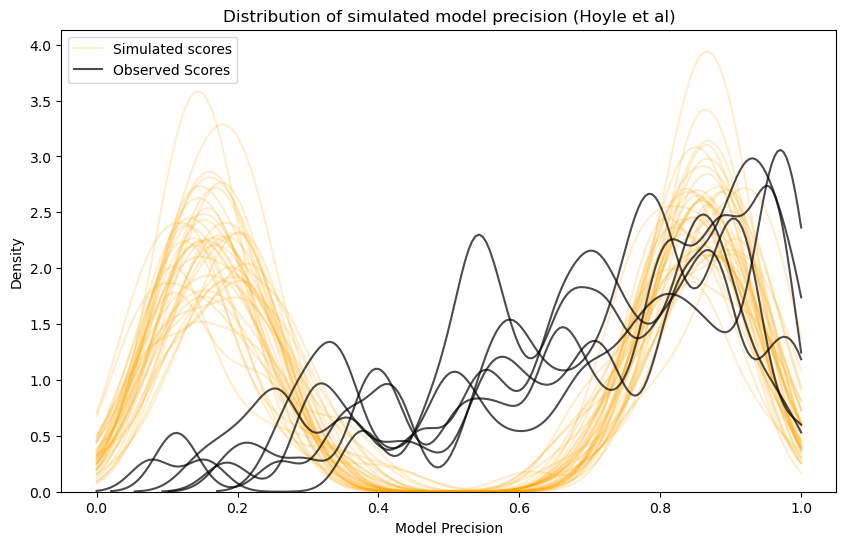

In [28]:
# Plotting Simulated Scores
scores_df = hoyle_scores
sim_cordel_id=1
sim_ids = [i for i in range(96)]
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# Plot one seperately for legend
df = scores_df[(scores_df["sim_cordel_id"]==sim_cordel_id)&
                        (scores_df["sim_id"]==0)]
sns.kdeplot(df["model_precision"], alpha=0.2, bw_adjust=bw_adjust,
            c="orange", label="Simulated scores", ax=ax, clip=(0,1))
for sim_id in sim_ids[1:]:
    df = scores_df[(scores_df["sim_cordel_id"]==sim_cordel_id)&
                            (scores_df["sim_id"]==sim_id)]
    sns.kdeplot(df["model_precision"], alpha=0.2, bw_adjust=bw_adjust,
                c="orange", ax=ax, clip=(0,1))
    
# Plotting Observed Scores
scores_df = obs_scores
df = scores_df[(scores_df["cordel_id"]==0)]
sns.kdeplot(df["model_precision"], alpha=0.7, bw_adjust=bw_adjust, 
            c="black", ax=ax, clip=(0,1), label="Observed Scores")
for cordel_id in range(1,6):
    df = scores_df[(scores_df["cordel_id"]==cordel_id)]
    sns.kdeplot(df["model_precision"], alpha=0.7, bw_adjust=bw_adjust, c="black", ax=ax, clip=(0,1))
ax.set_title("Distribution of simulated model precision (Hoyle et al)")
ax.set_xlabel("Model Precision")
ax.set_ylabel("Density")
ax.legend()
plt.show()

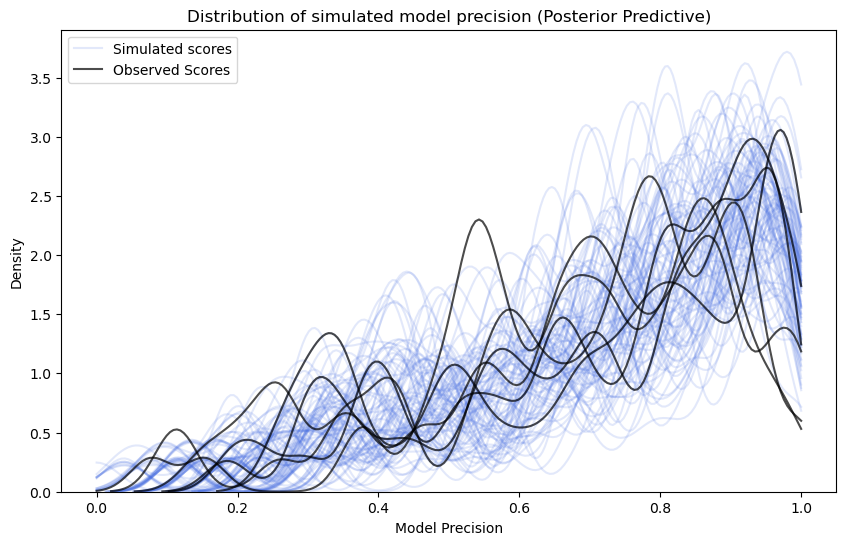

In [29]:
# Plotting Simulated Scores
scores_df = postrr_scores
sim_cordel_id=1
sim_ids = [i for i in range(96)]
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# Plot one seperately for legend
df = scores_df[(scores_df["sim_cordel_id"]==sim_cordel_id)&
                        (scores_df["sim_id"]==0)]
sns.kdeplot(df["model_precision"], alpha=0.15, bw_adjust=bw_adjust,
            c="royalblue", label="Simulated scores", ax=ax, clip=(0,1))
for sim_id in sim_ids[1:]:
    df = scores_df[(scores_df["sim_cordel_id"]==sim_cordel_id)&
                            (scores_df["sim_id"]==sim_id)]
    sns.kdeplot(df["model_precision"], alpha=0.15, bw_adjust=bw_adjust,
                c="royalblue", ax=ax, clip=(0,1))
    
# Plotting Observed Scores
scores_df = obs_scores
df = scores_df[(scores_df["cordel_id"]==0)]
sns.kdeplot(df["model_precision"], alpha=0.7, bw_adjust=bw_adjust, 
            c="black", ax=ax, clip=(0,1), label="Observed Scores")
for cordel_id in range(1,6):
    df = scores_df[(scores_df["cordel_id"]==cordel_id)]
    sns.kdeplot(df["model_precision"], alpha=0.7, bw_adjust=bw_adjust, c="black", ax=ax, clip=(0,1))

ax.set_title("Distribution of simulated model precision (Posterior Predictive)")
ax.set_xlabel("Model Precision")
ax.set_ylabel("Density")
ax.legend()
plt.show()

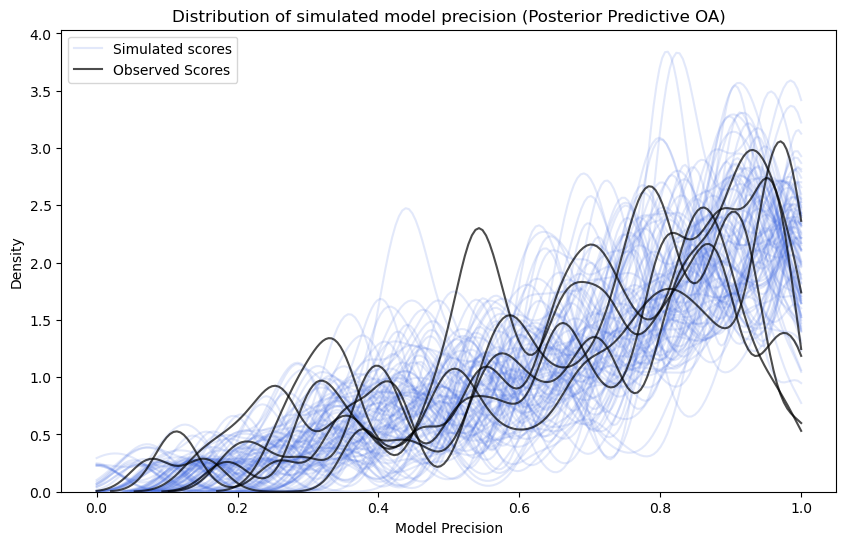

In [42]:
# Plotting Simulated Scores
scores_df = postrr_scoresOA
sim_cordel_id=1
sim_ids = [i for i in range(96)]
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# Plot one seperately for legend
df = scores_df[(scores_df["sim_cordel_id"]==sim_cordel_id)&
                        (scores_df["sim_id"]==0)]
sns.kdeplot(df["model_precision"], alpha=0.15, bw_adjust=bw_adjust,
            c="royalblue", label="Simulated scores", ax=ax, clip=(0,1))
for sim_id in sim_ids[1:]:
    df = scores_df[(scores_df["sim_cordel_id"]==sim_cordel_id)&
                            (scores_df["sim_id"]==sim_id)]
    sns.kdeplot(df["model_precision"], alpha=0.15, bw_adjust=bw_adjust,
                c="royalblue", ax=ax, clip=(0,1))
    
# Plotting Observed Scores
scores_df = obs_scores
df = scores_df[(scores_df["cordel_id"]==0)]
sns.kdeplot(df["model_precision"], alpha=0.7, bw_adjust=bw_adjust, 
            c="black", ax=ax, clip=(0,1), label="Observed Scores")
for cordel_id in range(1,6):
    df = scores_df[(scores_df["cordel_id"]==cordel_id)]
    sns.kdeplot(df["model_precision"], alpha=0.7, bw_adjust=bw_adjust, c="black", ax=ax, clip=(0,1))

ax.set_title("Distribution of simulated model precision (Posterior Predictive OA)")
ax.set_xlabel("Model Precision")
ax.set_ylabel("Density")
ax.legend()
plt.show()